# S2-RA-ETBF-export-from-zarr-workflow

**Date:** <br>
14 December 2021 <br>
**Background:** <br>
Issue -  <br>
**Author(s):**<br>
Thomas Moore<br>

### OOD documentation
https://opus.nci.org.au/display/DAE/Setting+up+a+Dask+Cluster+on+OOD

In [1]:
Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

In [2]:
import xarray as xr
import numpy as np
import xrft
import xesmf as xe
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
import cartopy.crs as ccrs
import proplot as pplt
from rechunker import rechunk
%config Completer.use_jedi = False

## import helper

In [3]:
import importlib.util
spec = importlib.util.spec_from_file_location("helper", "/g/data/v14/tm4888/code/helper-py/helper_tools.py")
helper = importlib.util.module_from_spec(spec)
spec.loader.exec_module(helper)

## OOD cluster

In [4]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,processes=1,memory="47GB",walltime='03:00:00')
client = Client(cluster)
cluster.scale(cores=24)

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.130:35051,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# load naitive grid zarr collections

In [6]:
%%time
ds_025_u = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.nativeUgrid.zarr',consolidated=True)
ds_025_v = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.nativeVgrid.zarr',consolidated=True)
ds_025_KE = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.nativeGrid.zarr',consolidated=True)
ds_025_Tocean = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.nativeTgrid.zarr',consolidated=True)

CPU times: user 151 ms, sys: 31.1 ms, total: 182 ms
Wall time: 252 ms


# Grid information for ACCESS S2?

In [7]:
%%time
ds_S2_Ugrid = xr.open_dataset('/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_1990.nc')
ds_S2_Vgrid = xr.open_dataset('/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_1990.nc')
ds_S2_Tgrid = xr.open_dataset('/g/data/ux62/access-s2/reanalysis/ocean/temp/mo_temp_1990.nc')

CPU times: user 94.1 ms, sys: 26.5 ms, total: 121 ms
Wall time: 160 ms


## depth weights

In [8]:
depth_weights = ds_S2_Tgrid.deptht_bounds.diff(dim='ndepth_bounds').squeeze().rename({'deptht':'depth'})
depth_weights.values

array([  1.0239066,   1.0792834,   1.1481192,   1.2337434,   1.3401852,
         1.4722052,   1.6352429,   1.8352118,   2.0780945,   2.369277 ,
         2.712654 ,   3.1096478,   3.5584164,   4.0536633,   4.5873146,
         5.150135 ,   5.7339096,   6.333458 ,   6.948097 ,   7.582039 ,
         8.244095 ,   8.946861 ,   9.705849 ,  10.538765 ,  11.465065 ,
        12.505692 ,  13.683044 ,  15.021072 ,  16.545197 ,  18.282547 ,
        20.261673 ,  22.512512 ,  25.065903 ,  27.952911 ,  31.204071 ,
        34.848145 ,  38.910614 ,  43.411926 ,  48.365784 ,  53.776886 ,
        59.638855 ,  65.93317  ,  72.62689  ,  79.67352  ,  87.01233  ,
        94.57056  , 102.265564 , 110.00891  , 117.70947  , 125.277954 ,
       132.63196  , 139.69739  , 146.41333  , 152.73181  , 158.6195   ,
       164.05664  , 169.03613  , 173.56226  , 177.64746  , 181.31226  ,
       184.5813   , 187.48242  , 190.04639  , 192.30273  , 194.28223  ,
       196.01294  , 197.52246  , 198.83594  , 199.97656  , 200.9

# update metadata

In [9]:
ds_025_KE.attrs['post processing']='generated by Thomas Moore from raw S2 u & v data on native grid'
ds_025_KE.EKE.attrs['standard_name']='EKE'
ds_025_KE.MKE.attrs['standard_name']='MKE'
ds_025_KE.time.attrs['axis']='time'
ds_025_KE.time.attrs['standard_name']='datetime64'

In [10]:
ds_025_u.time.attrs['axis']='time'
ds_025_u.time.attrs['standard_name']='datetime64'
ds_025_v.time.attrs['axis']='time'
ds_025_v.time.attrs['standard_name']='datetime64'
ds_025_Tocean.time.attrs['axis']='time'
ds_025_Tocean.time.attrs['standard_name']='datetime64'

# Replace Zeros with NaN's for land mask

In [11]:
ds_025_Tocean_masked = helper.replace_zero_w_nan(ds_025_Tocean)
ds_025_u_masked = helper.replace_zero_w_nan(ds_025_u)
ds_025_v_masked = helper.replace_zero_w_nan(ds_025_v)
ds_025_KE_masked = helper.replace_zero_w_nan(ds_025_KE)

# Regrid T-grid and check how it handles NaN's

## curvilinear grid

In [ ]:
nav_lon = ds_025_Tocean_masked['lon'].compute()
nav_lat = ds_025_Tocean_masked['lat'].compute()

In [ ]:
plt.scatter(nav_lon, nav_lat, s=0.01)  # plot grid locations
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.ylim([-80, 90])
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('ACCESS-S2 Curvilinear grid')

# CHOOSE YOUR NEW GRID // define uniform 1x1 grid

In [ ]:
new_1deg_grid = xe.util.grid_global(1, 1)
new_1deg_grid

In [ ]:
plt.scatter(new_1deg_grid.lon, new_1deg_grid.lat, s=0.01)  # plot grid locations
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('uniform grid')

In [ ]:
%%time
regridder_S2_1deg_Tgrid = xe.Regridder(ds_025_Tocean_masked, new_1deg_grid,'bilinear', ignore_degenerate=True, periodic=True,reuse_weights=False)

## EARTH SYSTEM MODELLING FRAMEWORK (NCAR / NOAA) - https://en.wikipedia.org/wiki/Earth_System_Modeling_Framework </br></br>  xESMF // https://github.com/JiaweiZhuang/xESMF/blob/master/README.rst

## $\bigstar$ solution to parallel regridding issue = https://github.com/JiaweiZhuang/xESMF/issues/71

#### regrid the full dataset object

In [ ]:
%%time
regridder_S2_1deg_Tgrid._grid_in = None
regridder_S2_1deg_Tgrid._grid_out = None
ds_Tocean_masked_1degRegrid = regridder_S2_1deg_Tgrid(ds_025_Tocean_masked)

In [ ]:
ds_Tocean_masked_1degRegrid = ds_Tocean_masked_1degRegrid.assign_coords({'x': ds_Tocean_masked_1degRegrid.lon.isel(y=0),'y': ds_Tocean_masked_1degRegrid.lat.isel(x=0)}).drop(['lon','lat']).rename({'x':'lon','y':'lat'})

## write function to pull back select attribute metadata

In [ ]:
def post_xesmf_attrs_fix(ds_source,ds_target,keys=['long_name','standard_name','units']):
    global_attrs = ds_source.attrs
    ds_out = ds_target.assign_attrs(global_attrs)
    ds_out['time'] = ds_out['time'].assign_attrs(ds_source['time'].attrs)
    for var in ds_source.var():
        copy_attrs = ds_source[var].attrs
        ds_out[var] = ds_out[var].assign_attrs({key: copy_attrs[key] for key in keys})
    return ds_out

In [ ]:
ds_Tocean_masked_1degRegrid = post_xesmf_attrs_fix(ds_025_Tocean_masked,ds_Tocean_masked_1degRegrid)

In [ ]:
ds_Tocean_masked_1degRegrid.nbytes/1e9

## Sanity check - SST

In [ ]:
%%time
regrid_data = ds_Tocean_masked_1degRegrid.sst.mean(dim='time').compute()
coarsened_data = ds_025_Tocean_masked.sst.mean(dim='time')
coarsened_data = coarsened_data.coarsen({'x':4,'y':4}, boundary="trim").mean().compute()

In [ ]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
fig.suptitle('compare regridded SST lon/lat to coarsened native x/y grid',fontsize=20)
regrid_data.plot(robust=True,ax=ax1)
coarsened_data.plot(robust=True,ax=ax2)
ax1.set_ylim([-60,0])
ax1.set_xlim([110,180])
ax2.set_ylim([50,125])
ax2.set_xlim([36,107])

# write 1deg Tgrid file to zarr

In [ ]:
ds_Tocean_masked_1degRegrid

In [ ]:
%%time
ds_Tocean_masked_1degRegrid.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.masked.Tregrid_1deg.zarr',consolidated=True)

# $\big\Downarrow$ export masked 1 degree NC files

# SST

In [ ]:
%%time
sst = ds_Tocean_masked_1degRegrid.sst
sst.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.sst.masked.grid1deg.nc')

# SSS

In [ ]:
%%time
sss = ds_Tocean_masked_1degRegrid.sss
sss.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.sss.masked.grid1deg.nc')

# mld1

In [ ]:
%%time
mld1 = ds_Tocean_masked_1degRegrid.mld1
mld1.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.mld1.masked.grid1deg.nc')

# mld2

In [ ]:
%%time
mld2 = ds_Tocean_masked_1degRegrid.mld2
mld2.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.mld2.masked.grid1deg.nc')

# td

In [ ]:
%%time
td = ds_Tocean_masked_1degRegrid.td
td.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.td.masked.grid1deg.nc')

# temp50

In [ ]:
%%time
temp50 = ds_Tocean_masked_1degRegrid.temp50
temp50.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.temp50.masked.grid1deg.nc')

# temp100

In [ ]:
%%time
temp100 = ds_Tocean_masked_1degRegrid.temp100
temp100.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.temp100.masked.grid1deg.nc')

# temp200

In [ ]:
%%time
temp200 = ds_Tocean_masked_1degRegrid.temp200
temp200.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.temp200.masked.grid1deg.nc')

# temp500

In [ ]:
%%time
temp500 = ds_Tocean_masked_1degRegrid.temp500
temp500.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.temp500.masked.grid1deg.nc')

# D20

In [ ]:
%%time
d20 = ds_Tocean_masked_1degRegrid.d20
d20.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.d20.masked.grid1deg.nc')

# hc300

In [ ]:
%%time
hc300 = ds_Tocean_masked_1degRegrid.hc300
hc300.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.hc300.masked.grid1deg.nc')

# temp sanity checks

In [ ]:
#build datasets
temp_1deg = xr.merge([temp50,temp100,temp200,temp500])

In [ ]:
import proplot as pplt
import numpy as np
pplt.rc.cycle = '538'
fig, axs = pplt.subplots(ncols=1, span=False, share='labels', refwidth=5.3)
labels = ['50', '100', '200', '500']
hs1 = []
region = {'lat':slice(-50,-15),'lon':slice(150,180)}
for i, label in enumerate(labels):
    var_string = 'temp'+label
    data = temp_1deg[var_string].sel(region).mean({'lat','lon'})
    h1 = axs[0].plot(
        data, lw=2, label=label, alpha=0.7
    )
    hs1.extend(h1)

# Outer legends
ax = axs[0]
ax.legend(hs1, loc='b', ncols=3, title='depth in metres', order='C', facecolor='gray2')
axs.format(xlabel='date', ylabel='temp', suptitle='ocean temp sanity check - 1deg grid')

# U regrid

In [ ]:
ds_025_u_masked

In [ ]:
ds_025_u_masked = ds_025_u_masked.chunk({'y':1021, 'x':1442}) #xesmf hates chunks across grid vars?

In [ ]:
%%time
regridder_S2_1deg_Ugrid = xe.Regridder(ds_025_u_masked, new_1deg_grid,'bilinear', ignore_degenerate=True, periodic=True,reuse_weights=False)

## EARTH SYSTEM MODELLING FRAMEWORK (NCAR / NOAA) - https://en.wikipedia.org/wiki/Earth_System_Modeling_Framework </br></br>  xESMF // https://github.com/JiaweiZhuang/xESMF/blob/master/README.rst

## $\bigstar$ solution to parallel regridding issue = https://github.com/JiaweiZhuang/xESMF/issues/71

#### regrid the full dataset object

In [ ]:
%%time
regridder_S2_1deg_Ugrid._grid_in = None
regridder_S2_1deg_Ugrid._grid_out = None
ds_ACCESS_S2_RA_ocean_u_masked_1degRegrid = regridder_S2_1deg_Ugrid(ds_025_u_masked)

In [ ]:
ds_ACCESS_S2_RA_ocean_u_masked_1degRegrid = helper.post_xesmf_attrs_fix(ds_025_u_masked,ds_ACCESS_S2_RA_ocean_u_masked_1degRegrid)

# V regrid

In [ ]:
ds_025_v_masked = ds_025_v_masked.chunk({'y':1021, 'x':1442}) #xesmf hates chunks across grid vars?

In [ ]:
%%time
regridder_S2_1deg_Vgrid = xe.Regridder(ds_025_v_masked, new_1deg_grid,'bilinear', ignore_degenerate=True, periodic=True,reuse_weights=False)

## EARTH SYSTEM MODELLING FRAMEWORK (NCAR / NOAA) - https://en.wikipedia.org/wiki/Earth_System_Modeling_Framework </br></br>  xESMF // https://github.com/JiaweiZhuang/xESMF/blob/master/README.rst

## $\bigstar$ solution to parallel regridding issue = https://github.com/JiaweiZhuang/xESMF/issues/71

#### regrid the full dataset object

In [ ]:
%%time
regridder_S2_1deg_Vgrid._grid_in = None
regridder_S2_1deg_Vgrid._grid_out = None
ds_ACCESS_S2_RA_ocean_v_masked_1degRegrid = regridder_S2_1deg_Vgrid(ds_025_v_masked)

In [ ]:
ds_ACCESS_S2_RA_ocean_v_masked_1degRegrid = post_xesmf_attrs_fix(ds_025_v_masked,ds_ACCESS_S2_RA_ocean_v_masked_1degRegrid)

In [ ]:
ds_ACCESS_S2_RA_ocean_v_masked_1degRegrid = ds_ACCESS_S2_RA_ocean_v_masked_1degRegrid.assign_coords(
    {'x': ds_ACCESS_S2_RA_ocean_v_masked_1degRegrid.lon.isel(y=0),
    'y': ds_ACCESS_S2_RA_ocean_v_masked_1degRegrid.lat.isel(x=0)}).drop(
    ['lon','lat']).rename({'x':'lon','y':'lat'})

In [ ]:
ds_ACCESS_S2_RA_ocean_u_masked_1degRegrid = ds_ACCESS_S2_RA_ocean_u_masked_1degRegrid.assign_coords(
    {'x': ds_ACCESS_S2_RA_ocean_u_masked_1degRegrid.lon.isel(y=0),
    'y': ds_ACCESS_S2_RA_ocean_u_masked_1degRegrid.lat.isel(x=0)}).drop(
    ['lon','lat']).rename({'x':'lon','y':'lat'})

# write out the 1deg u & v zarr collections

In [ ]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.masked.regrid_1deg.zarr
ds_ACCESS_S2_RA_ocean_u_masked_1degRegrid.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.masked.regrid_1deg.zarr',
                                           consolidated=True)

In [ ]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.masked.regrid_1deg.zarr
ds_ACCESS_S2_RA_ocean_v_masked_1degRegrid.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.masked.regrid_1deg.zarr',
                                           consolidated=True)

# Load 1deg U&V from zarr

In [12]:
ds_u = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.masked.regrid_1deg.zarr')
ds_v = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.masked.regrid_1deg.zarr')

# sanity check

In [ ]:
ds_u.u.isel(time=0).max('depth').plot()

In [ ]:
ds_v.v.isel(time=0).max('depth').plot()

# U100

In [14]:
%%time
u100 = ds_u.u.sel(depth=100,method='nearest')
u100 = u100.to_dataset(name='u100')
u100.attrs['post_processing']='generated by Thomas Moore from S2 u data using nearest method'
u100.u100.attrs['standard_name']='u100'
u100.u100.attrs['long_name']='x velocity at 100m'
u100.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.u100.masked.grid1deg.nc')

CPU times: user 1.18 s, sys: 172 ms, total: 1.35 s
Wall time: 9.75 s


# V100

In [15]:
%%time
v100 = ds_v.v.sel(depth=100,method='nearest')
v100 = v100.to_dataset(name='v100')
v100.attrs['post_processing']='generated by Thomas Moore from S2 v data using nearest method'
v100.v100.attrs['standard_name']='v100'
v100.v100.attrs['long_name']='y velocity at 100m'
v100.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.v100.masked.grid1deg.nc')

CPU times: user 1.01 s, sys: 146 ms, total: 1.16 s
Wall time: 9.11 s


# u100_300

## need to use depth weighted mean

In [16]:
u100_300 = helper.weighted_ocean_mean(ds_u.u,weights=depth_weights,dim='depth',sel_dict={'depth':slice(100,300)})

In [17]:
u100_300 = u100_300.to_dataset(name='u100_300')

In [18]:
u100_300.attrs['post_processing']='generated by Thomas Moore from S2 u data after masking and regridding to 1deg'
u100_300.u100_300.attrs['standard_name']='u100_300'
u100_300.u100_300.attrs['long_name']='x velocity depth weighted mean between 100-300m'
u100_300.u100_300.attrs['units']='m/s'

In [20]:
%%time
u100_300.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.u100_300.masked.grid1deg.nc')

CPU times: user 4.17 s, sys: 614 ms, total: 4.79 s
Wall time: 26.5 s


# v100_300

## need to use depth weighted mean

In [21]:
%%time
v100_300 = helper.weighted_ocean_mean(ds_v.v,weights=depth_weights,dim='depth',sel_dict={'depth':slice(100,300)})

CPU times: user 45.8 ms, sys: 1.93 ms, total: 47.7 ms
Wall time: 45.7 ms


In [22]:
v100_300 = v100_300.to_dataset(name='v100_300')
v100_300.attrs['post_processing']='generated by Thomas Moore from S2 v data after masking and regridding to 1deg'
v100_300.v100_300.attrs['standard_name']='v100_300'
v100_300.v100_300.attrs['long_name']='y velocity depth weighted mean between 100-300m'
v100_300.v100_300.attrs['units']='m/s'

In [24]:
%%time
v100_300.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.v100_300.masked.grid1deg.nc')

CPU times: user 1.51 s, sys: 172 ms, total: 1.68 s
Wall time: 7.87 s


# Calc EKE from regridded u & v

In [25]:
[EKE,MKE] = helper.calc_EKE(ds_u.u,ds_v.v)

In [26]:
ds_KE_masked = xr.merge([EKE,MKE])

In [27]:
ds_KE_masked.attrs['post_processing']='generated by Thomas Moore from raw S2 u & v data on native grid'
ds_KE_masked.EKE.attrs['standard_name']='EKE'
ds_KE_masked.MKE.attrs['standard_name']='MKE'

In [28]:
ds_KE_masked

<xarray.Dataset>
Dimensions:  (depth: 75, lat: 180, lon: 360, time: 480)
Coordinates:
  * depth    (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) datetime64[ns] 1981-01-16 1981-02-15 ... 2020-12-01
Data variables:
    EKE      (time, depth, lat, lon) float32 dask.array<chunksize=(480, 1, 180, 360), meta=np.ndarray>
    MKE      (depth, lat, lon) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes:
    post_processing:  generated by Thomas Moore from raw S2 u & v data on nat...

# sanity check

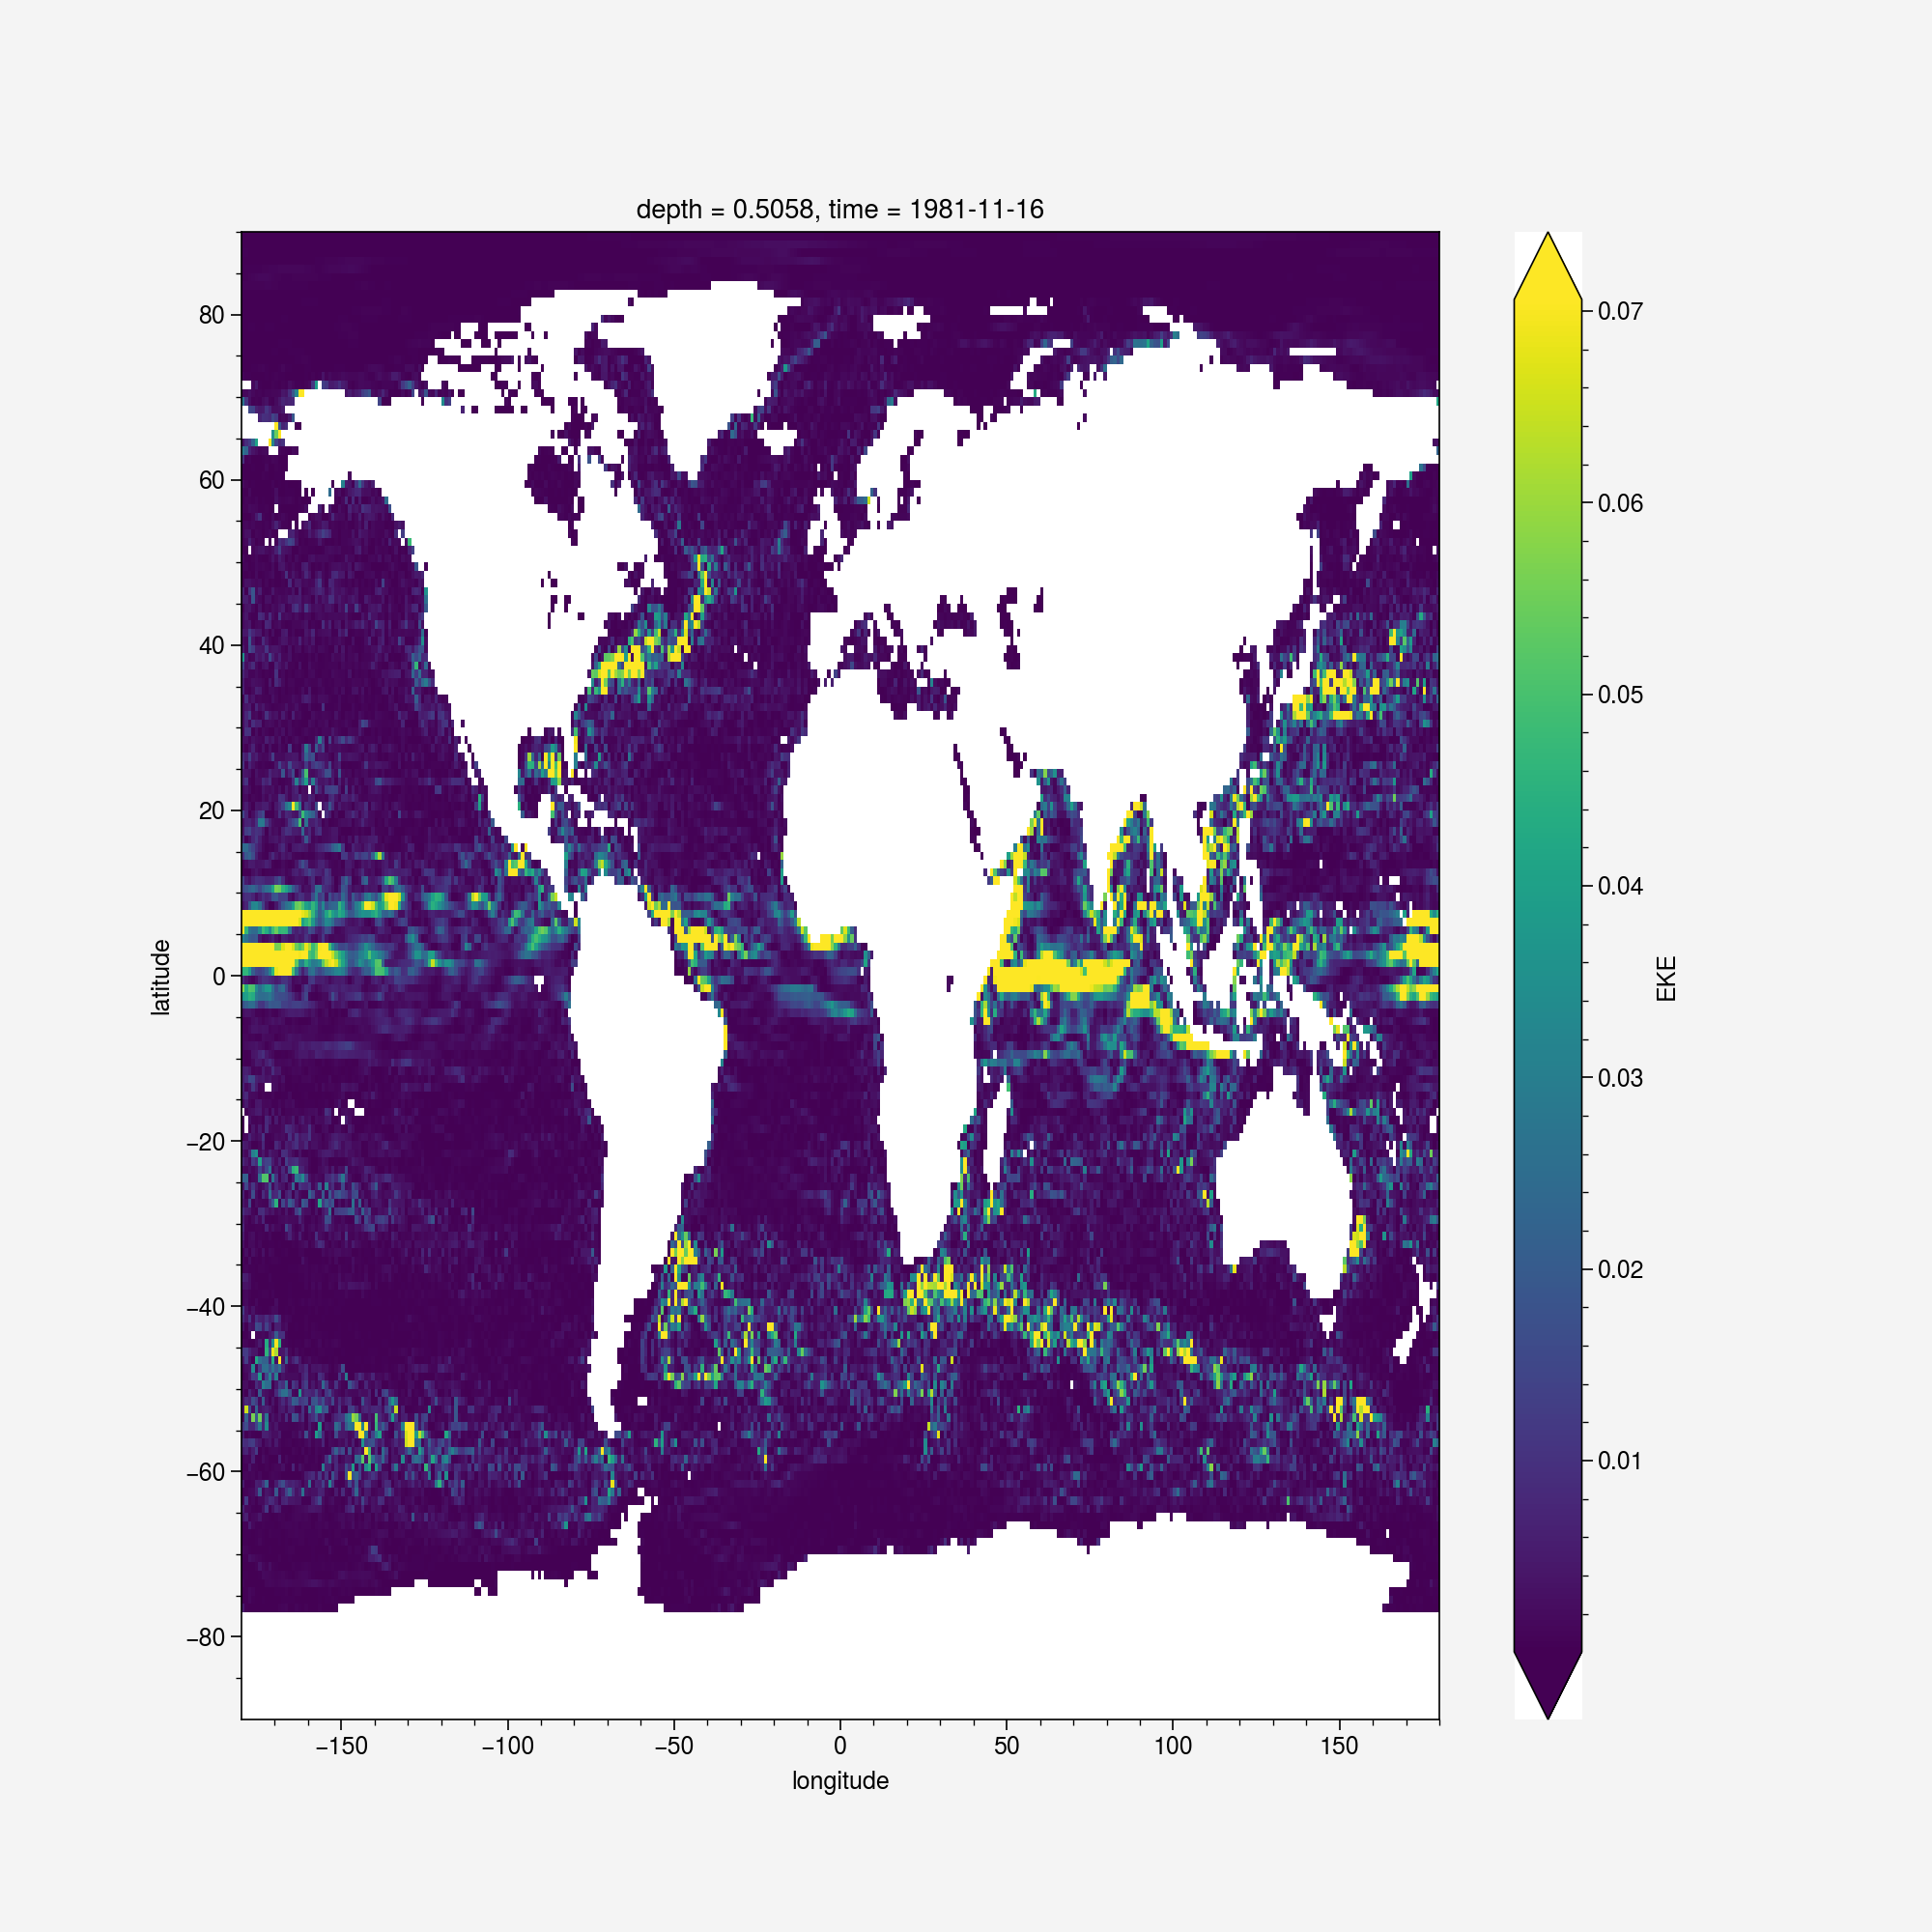

In [29]:
ds_KE_masked.EKE.isel({'depth':0,'time':10}).plot(robust=True,size=10)

# EKE_300

## need to account for variable cell thickness without formal integration

In [30]:
eke = ds_KE_masked.EKE

In [31]:
eke300 = (eke * depth_weights).sel(depth=slice(0,300)).sum('depth',skipna=False)
eke300 = eke300.to_dataset(name='eke300')
eke300.attrs['post_processing']='generated by Thomas Moore from S2 u & v data after masking zeros and regridding'
eke300.eke300.attrs['standard_name']='eke300'
eke300.eke300.attrs['long_name']='eke depth weighted sum 0-300m'

In [ ]:
eke300

In [32]:
%%time
eke300.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.eke300.masked.grid1deg.nc')

CPU times: user 3.33 s, sys: 400 ms, total: 3.73 s
Wall time: 15.5 s


# EKE_2000

## need to account for variable cell thickness without formal integration

In [33]:
eke2000 = (eke * depth_weights).sel(depth=slice(0,2000)).sum('depth',skipna=False)
eke2000 = eke2000.to_dataset(name='eke2000')
eke2000.attrs['post_processing']='generated by Thomas Moore from S2 u & v data after masking zeros and regridding'
eke2000.eke2000.attrs['standard_name']='eke2000'
eke2000.eke2000.attrs['long_name']='eke depth weighted sum 0-2000m'

In [34]:
%%time
eke2000.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.eke2000.masked.grid1deg.nc')

CPU times: user 3.21 s, sys: 337 ms, total: 3.55 s
Wall time: 10.5 s


In [ ]:
eke2000

# $\big\Uparrow$ This has been run on 15 December 2021

# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [ ]:
client.restart()

In [35]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [ ]:
client.restart()